# Projet n°6: Classifiez automatiquement des biens de consommations 
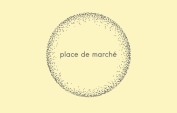

## Traitement des images
### Import des librairies et packages

In [1]:
#!pip install opencv-python

In [2]:
import pandas as pd
import numpy as np
import time

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

from scipy.ndimage import gaussian_filter
import cv2
from PIL import Image, ImageFilter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
path = "Images/"

In [4]:
data = pd.read_csv("data.csv")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
data.sample()

,product_name,image,description,brand,categ_principale,words
520,maximum lpgy analog watch men,b64149a8a9235f5199c6d8225d5dc602.jpg,maximum lpgy analog watch men maximum lpgy ana...,NaN,Watches,maximum lpgy analog watch men maximum lpgy ana...


In [6]:
def drop_col(df):
    df.drop(columns=['product_name', 'description', 'brand', 'words'], inplace=True)
    return df

In [7]:
data = drop_col(data)
train = drop_col(train)
test = drop_col(test)

### Parcours des données (Affichage d'échantillon)

In [8]:
def list_fct(name) :
    list_image_name = [data["image"].iloc[i] for i in range(len(data)) if data["categ_principale"][i]==name]
    return list_image_name

Home Furnishing


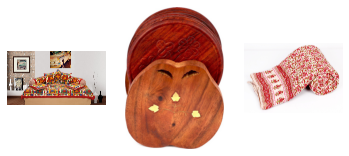

Baby Care


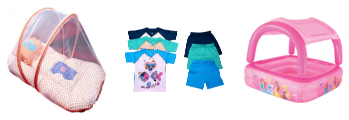

Watches


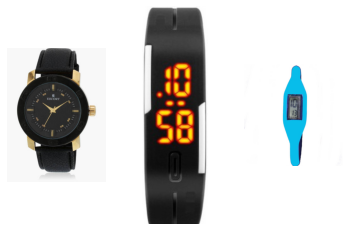

Home Decor & Festive Needs


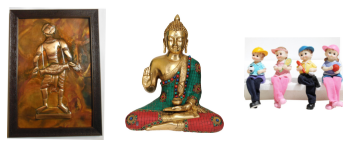

Kitchen & Dining


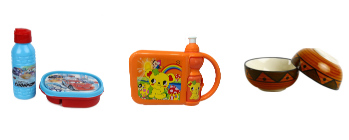

Beauty and Personal Care


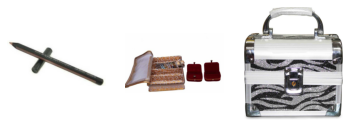

Computers


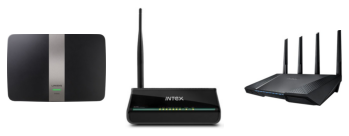

In [9]:
for name in data["categ_principale"].unique() :
    print(name)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + list_fct(name)[i+10]
        image = imread(filename)
        plt.axis("off")
        plt.imshow(image)
        plt.savefig("{}.png".format(name), transparent=True)
    plt.show()

In [10]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    '''redimensionnement des images:
    * filtre gaussian
    * égalisation de l'histogramme
    * redimensionnement
    prend un entrée le chemin vers l'image et en sortie la matrice np.array de l'image traitée
    '''    
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

#### Test de pré-traitement d'image sur un échantillon

On réalise divers test sur une image donnée (la première du dataset)

In [11]:
pic = imread(path+data['image'].iloc[0])
print("Taille de la matrice de pixels : {}".format(pic.shape))

Taille de la matrice de pixels : (3600, 3600, 3)


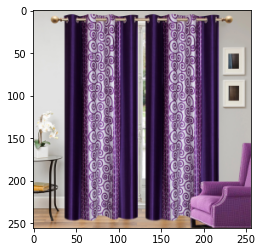

In [12]:
small = image_resize(pic, width=256)
plt.imshow(small)
plt.savefig("small.png")

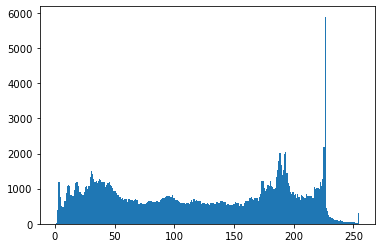

In [13]:
n, bins, patches = plt.hist(small.flatten(), bins=range(256))
plt.savefig("hist_small.png", transparent=True)
plt.show()

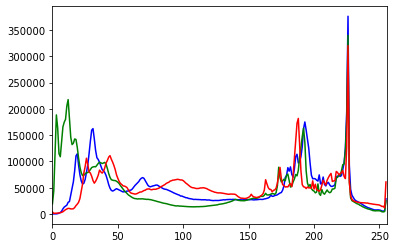

In [14]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([pic],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.savefig("hist_rgb.png", transparent=True)

In [15]:
blur = gaussian_filter(small, sigma=1)

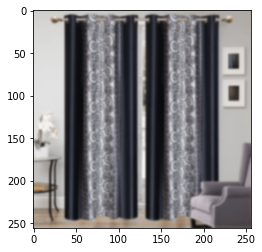

In [16]:
plt.imshow(blur)
plt.savefig("blur.png")

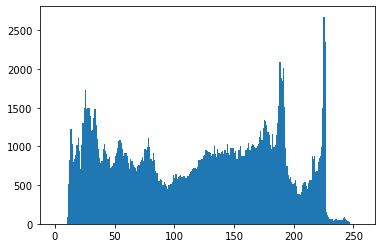

In [17]:
n, bins, patches = plt.hist(blur.flatten(), bins=range(256))
plt.savefig("hist_blur.png", transparent=True)
plt.show()

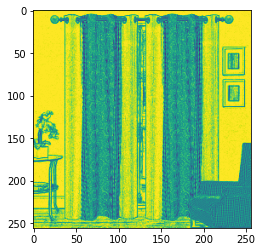

In [18]:
th3 = cv2.imread(path+data['image'].iloc[0], 0)
th3 = image_resize(cv2.adaptiveThreshold(th3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2), width=256)
plt.imshow(th3)
plt.savefig("thresh.png")

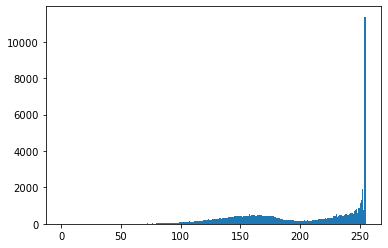

In [19]:
n, bins, patches = plt.hist(th3.flatten(), bins=range(256))
plt.savefig("hist_th.png", transparent=True)
plt.show()

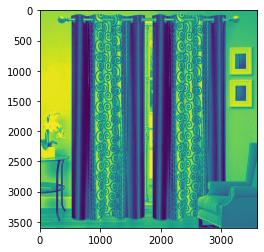

In [20]:
eq = cv2.imread(path+data['image'].iloc[0], 0)
eq = cv2.equalizeHist(eq)
plt.imshow(eq)
plt.savefig("eq.png")

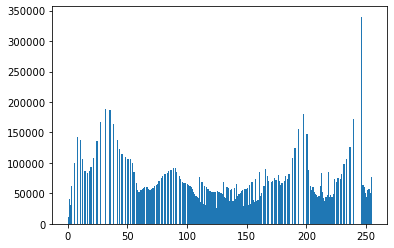

In [21]:
n, bins, patches = plt.hist(eq.flatten(), bins=range(256))
plt.savefig("hist_eq.png", transparent=True)
plt.show()

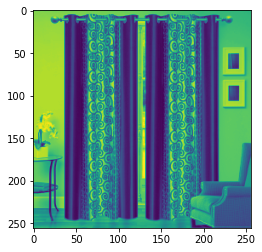

In [22]:
gray = image_resize(cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY), width=256)
plt.imshow(gray)
plt.savefig("gray.png")

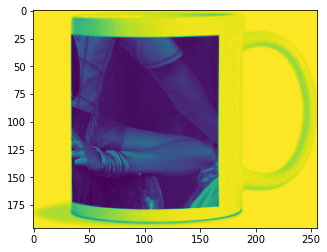

In [23]:
img = imread(path+data['image'].iloc[148])
img_gray = image_resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), width=256)
plt.imshow(img_gray)

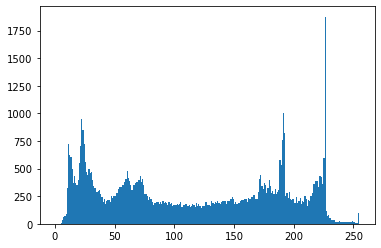

In [24]:
n, bins, patches = plt.hist(gray.flatten(), bins=range(256))
plt.savefig("hist_gray.png", transparent=True)
plt.show()

#### Test du SIFT sur échantillon

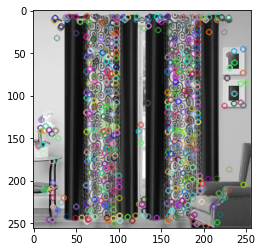

In [25]:
sift = cv2.SIFT_create()

keypoints, descriptors = sift.detectAndCompute(gray,None)
img = cv2.drawKeypoints(gray,keypoints,pic)

plt.imshow(img)
plt.savefig("kp.png")

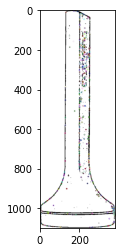

(620, 128)
Game Over


In [26]:
image = cv2.imread(path+data["image"].iloc[354],0) # converti en niveau de gris
#image = cv2.equalizeHist(image)
#clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8, 8))
#image = clahe.apply(image)
image = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,1)
image = cv2.medianBlur(image, 5)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
try:
    print(des.shape)
except AttributeError as err:
    print("Pas de keypoint")
    print('GB')


print("Game Over")

# Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image
* Pour chaque image passage en gris, resize et  equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [27]:
le = LabelEncoder()
data["cat"] = le.fit_transform(data["categ_principale"])

In [28]:
img_size = 256

In [29]:
# identification des points clé et descripteurs associés

sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create(500)

for image_num in range(len(data["image"])) :
    if image_num%100 == 0 : print("Nombre d'images traitées: ",image_num)
    image = cv2.imread(path+data["image"].iloc[image_num], 0)
    image = image_resize(image, width=img_size)
    image = cv2.equalizeHist(image)
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print("Images traitées: ", len(data["image"]))
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%5.2f" % duration1, "secondes")

Nombre d'images traitées:  0
Nombre d'images traitées:  100
Nombre d'images traitées:  200
Nombre d'images traitées:  300
Nombre d'images traitées:  400
Nombre d'images traitées:  500
Nombre d'images traitées:  600
Nombre d'images traitées:  700
Nombre d'images traitées:  800
Nombre d'images traitées:  900
Nombre d'images traitées:  1000
Images traitées:  1050
Nombre de descripteurs :  (370223, 128)
temps de traitement SIFT descriptor :  44.99 secondes


C:\Users\Mathieu\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [30]:
# Determination du nombre de cluster
temps=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration=time.time()-temps
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  608
Création de 608 clusters de descripteurs ...


C:\Users\Mathieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


temps de traitement kmeans :            44.99 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

In [31]:
# Creation des histogrammes (features)
temps=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des #Division par le nb de descripteurs pour pondérer le poids des descripteurs
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) : 
    hist = build_histogram(kmeans, image_desc, i) #calcul de l'histogramme
    hist_vectors.append(hist) 

im_features = np.asarray(hist_vectors)

duration=time.time()-temps
print("temps de création histogrammes : ", "%5.2f" % duration, "secondes")

temps de création histogrammes :   2.54 secondes


In [32]:
im_features.shape

(1050, 608)

## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [33]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 608)
Dimensions dataset après réduction PCA :  (1050, 479)


### Division en train/test set 
#### Application d'un classifier

##### SVC

In [34]:
X_train, X_test, y_train, y_test = train_test_split(feat_pca, data["categ_principale"], random_state= 9, test_size=0.20)

In [35]:
svc = SVC()

In [36]:
svc.fit(X_train, y_train)

SVC()

In [37]:
result_svc = svc.predict(X_test)

In [38]:
svc.score(X_test, y_test)

0.5476190476190477

In [39]:
svc.classes_

array(['Baby Care', 'Beauty and Personal Care', 'Computers',
       'Home Decor & Festive Needs', 'Home Furnishing',
       'Kitchen & Dining', 'Watches'], dtype=object)

In [40]:
print(classification_report(y_test, result_svc, target_names=svc.classes_))

                            precision    recall  f1-score   support

                 Baby Care       0.33      0.39      0.36        23
  Beauty and Personal Care       0.74      0.66      0.70        35
                 Computers       0.41      0.42      0.42        33
Home Decor & Festive Needs       0.61      0.59      0.60        34
           Home Furnishing       0.52      0.55      0.53        31
          Kitchen & Dining       0.53      0.42      0.47        24
                   Watches       0.67      0.73      0.70        30

                  accuracy                           0.55       210
                 macro avg       0.54      0.54      0.54       210
              weighted avg       0.55      0.55      0.55       210



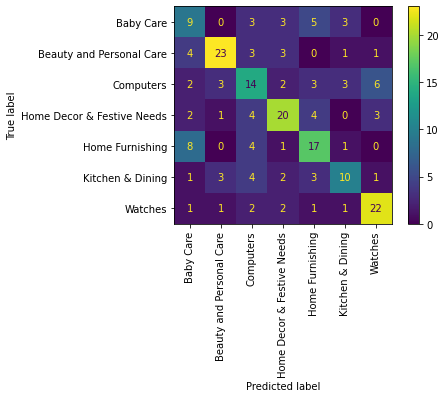

In [41]:
cm_svc = confusion_matrix(y_test, result_svc, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                               display_labels=svc.classes_)
disp.plot()
disp.ax_.tick_params(axis='x', labelrotation=90)
plt.savefig("cm_svc.png", bbox_inches="tight", transparent=True)
plt.show()

##### MLP

In [42]:
mlp = MLPClassifier(max_iter=2000)
mlp.fit(X_train, y_train)

MLPClassifier(max_iter=2000)

In [43]:
result_mlp = mlp.predict(X_test)

In [44]:
mlp.score(X_test, y_test)

0.49047619047619045

In [45]:
print(classification_report(y_test, result_mlp, target_names=mlp.classes_))

                            precision    recall  f1-score   support

                 Baby Care       0.30      0.48      0.37        23
  Beauty and Personal Care       0.56      0.57      0.56        35
                 Computers       0.57      0.52      0.54        33
Home Decor & Festive Needs       0.53      0.53      0.53        34
           Home Furnishing       0.39      0.35      0.37        31
          Kitchen & Dining       0.47      0.33      0.39        24
                   Watches       0.64      0.60      0.62        30

                  accuracy                           0.49       210
                 macro avg       0.49      0.48      0.48       210
              weighted avg       0.50      0.49      0.49       210



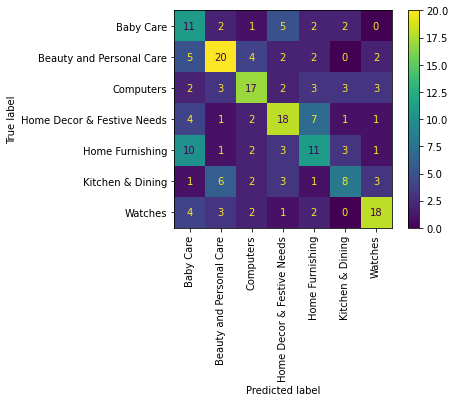

In [46]:
cm_mlp = confusion_matrix(y_test, result_mlp, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp,
                               display_labels=mlp.classes_)
disp.plot()
disp.ax_.tick_params(axis='x', labelrotation=90)
plt.savefig("cm_mlp.png", bbox_inches="tight", transparent=True)
plt.show()

Les resultats sont mitigés, la machine peine à retrouver les catégories avec les descripteurs SIFT.

### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [47]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["categ_principale"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images


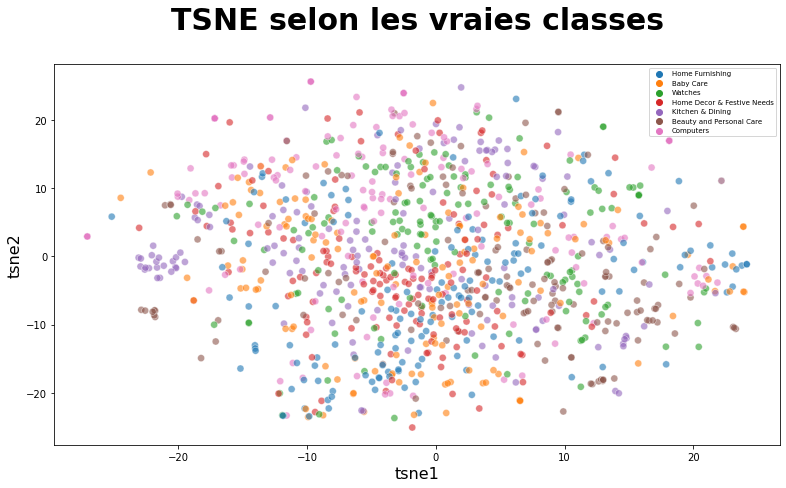

In [48]:
plt.figure(figsize=(13,7))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 16)
plt.ylabel('tsne2', fontsize = 16)
plt.legend(prop={'size': 7}) 

plt.savefig("tsne.png", transparent=True)
plt.show()


Difficile de retrouver des clusters définis en fonction des catégories.

## Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [49]:
cls = KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


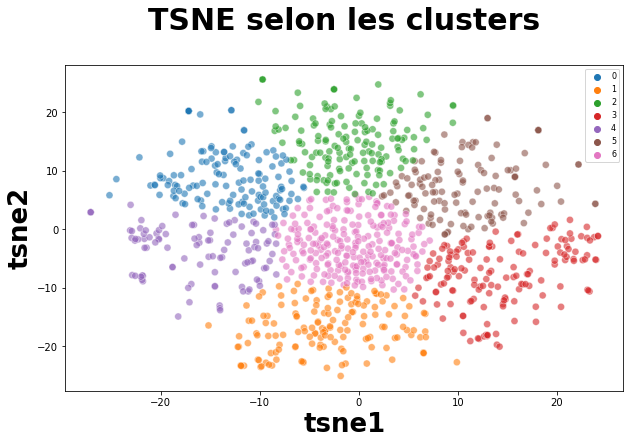

ARI :  0.045103578405533286


In [50]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

labels = data["cat"]
print("ARI : ", adjusted_rand_score(labels, cls.labels_))

Comme on l'avait remarqué les clusters trouvés ne correspondent pas du tout aux véritables classes.  
Le score ARI est très faible.  


### Analyse par classes


In [51]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    137
1    150
2    151
3    153
4    102
5    122
6    235
Name: class, dtype: int64

In [52]:
conf_mat =  confusion_matrix(labels, cls.labels_)
print(conf_mat)
print()
print(classification_report(labels, cls.labels_))

[[28 33 10 11 15 16 37]
 [ 9  7 17 56 17 20 24]
 [40 13 44 14  7 21 11]
 [18 29 15  5 13 11 59]
 [13 47  3 22  8 17 40]
 [17 10 28 17 32 10 36]
 [12 11 34 28 10 27 28]]

              precision    recall  f1-score   support

           0       0.20      0.19      0.20       150
           1       0.05      0.05      0.05       150
           2       0.29      0.29      0.29       150
           3       0.03      0.03      0.03       150
           4       0.08      0.05      0.06       150
           5       0.08      0.07      0.07       150
           6       0.12      0.19      0.15       150

    accuracy                           0.12      1050
   macro avg       0.12      0.12      0.12      1050
weighted avg       0.12      0.12      0.12      1050



<AxesSubplot:>

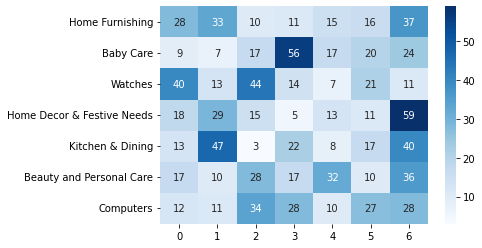

In [53]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in data["categ_principale"].unique()],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion n'a ici pas de sens puisqu'on ne sait pas que représente les labels 0,1,2,3,... 
Il est impossible de conclure quoique ce soit.
